In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from random import sample
import re
%matplotlib inline

In [ ]:
start_token = " "

with open("/content/pushkin.txt") as f:
    text = f.read()[:-1].split('\n')
    text = [re.sub(r'[^\w\s]', '', line.replace('-', ' ').lower()) for line in text]

In [ ]:
text

['жил был поп',
 'толоконный лоб',
 'пошел поп по базару',
 'посмотреть кой какого товару',
 'навстречу ему балда',
 'идет сам не зная куда',
 'что батька так рано поднялся',
 'чего ты взыскался',
 'поп ему в ответ нужен мне работник',
 'повар конюх и плотник',
 'а где найти мне такого',
 'служителя не слишком дорогого',
 'балда говорит буду служить тебе славно',
 'усердно и очень исправно',
 'в год за три щелка тебе по лбу',
 'есть же мне давай вареную полбу',
 'призадумался поп',
 'стал себе почесывать лоб',
 'щелк щелку ведь розь',
 'да понадеялся он на русский авось',
 'пон говорит балде ладно',
 'не будет нам обоим накладно',
 'поживи ка на моем подворье',
 'окажи свое усердие и проворье',
 'живет балда в поповом доме',
 'спит себе на соломе',
 'ест за четверых',
 'работает за семерых',
 'до светла все у него пляшет',
 'лошадь запряжет полосу вспашет',
 'печь затопит все заготовит закупит',
 'яичко испечет да сам и облупит',
 'попадья балдой не нахвалится',
 'поповна о балде лишь 

max length = 71


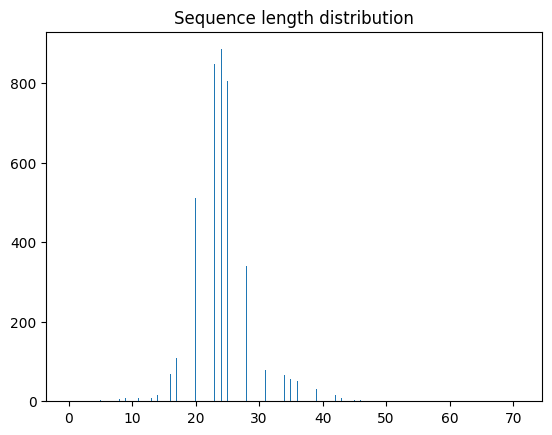

In [ ]:
MAX_LENGTH = max(map(len, text))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, text)),bins=1000);

In [ ]:
#all unique characters go here
tokens = set()
for line in text:
    for word in line.split():
       # print(word)
        tokens.add(word)


 #<all unique characters in the dataset>

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

#assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  10959


In [ ]:
tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
tokens.append('_') # <PAD>
tokens.append(' ') # пробел

In [ ]:
len(tokens)

10963

In [ ]:
tokens[10959]

'<'

In [ ]:
tokens[10960]

'>'

In [ ]:
tokens[10961]

'_'

In [ ]:
tokens[10962]

' '

In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)} # <dictionary of symbol -> its identifier (index in tokens list)>

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(
    text, max_len=None, pad=token_to_id['_'], dtype='int32', batch_first=True
    ):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max([len(re.split("(\ )", item)) for item in text])

    max_len += 2

    text_ix = np.zeros([len(text), max_len], dtype) + pad




    text_ix[:, 0] = token_to_id['<'] # <SOS>


    for i in range(len(text)):

        line_ix = [token_to_id[c] for c in [item for item in re.split("(\ )", text[i])]]

        text_ix[i, 1:len(line_ix)+1] = line_ix[:]
        text_ix[i, len(line_ix)+1] = token_to_id['>'] # <EOS>'''





    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [ ]:
text[::2000]

['жил был поп',
 'ославили в суде взаимный их позор',
 'владимир сухо отвечал',
 'и вновь задумчивый унылый']

In [ ]:
re.split("(\ )", 'жил был поп')

['жил', ' ', 'был', ' ', 'поп']

In [ ]:
print('\n'.join(text[::2000]))

жил был поп
ославили в суде взаимный их позор
владимир сухо отвечал
и вновь задумчивый унылый


In [ ]:
print(to_matrix(text[::2000]))

[[10959  4823 10962  2856 10962  8997 10960 10961 10961 10961 10961 10961
  10961]
 [10959  8898 10962 10451 10962  2738 10962  3937 10962  7859 10962  3300
  10960]
 [10959  9105 10962   565 10962 10908 10960 10961 10961 10961 10961 10961
  10961]
 [10959  6829 10962  7678 10962  8388 10962  7106 10960 10961 10961 10961
  10961]]


In [ ]:
' '.join([tokens[idx] for idx in to_matrix(text[::2000])[3]])

'< и   вновь   задумчивый   унылый > _ _ _ _'

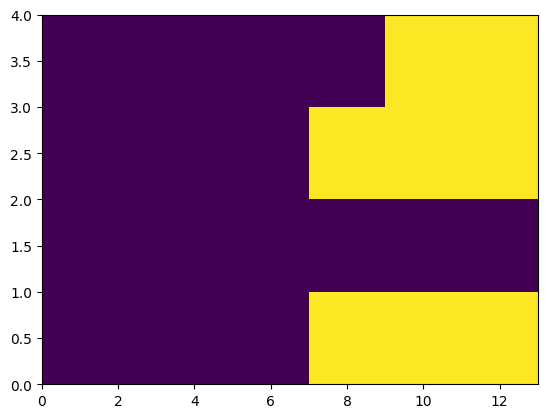

In [ ]:
plt.pcolormesh(to_matrix(text[::2000]) == 10961)

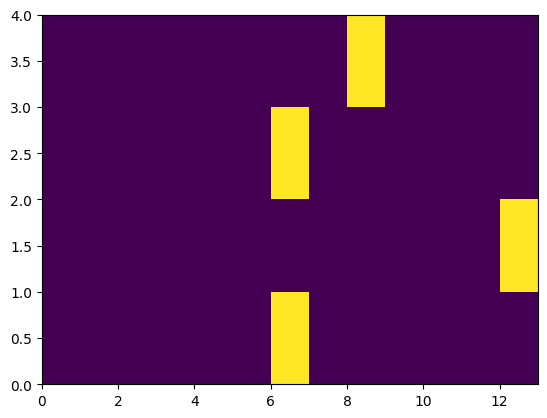

In [ ]:
plt.pcolormesh(to_matrix(text[::2000]) == 10960)

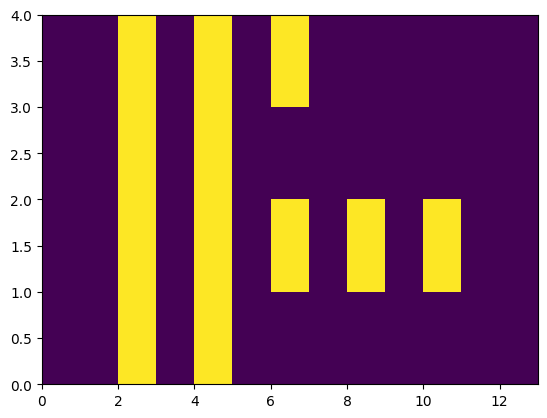

In [ ]:
plt.pcolormesh(to_matrix(text[::2000]) == 10962)

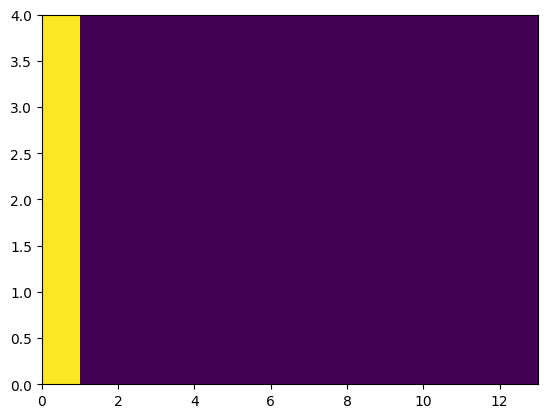

In [ ]:
plt.pcolormesh(to_matrix(text[::2000]) == 10959)

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        #print('x', x)
        # get vector embedding of x
        x_emb = self.embedding(x)

        #print('x_emb', x_emb)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1) #YOUR CODE HERE
        #print('x_and_h', x_and_h)
        h_next = self.rnn_update(x_and_h)



        h_next = torch.tanh(h_next) #YOUR CODE HERE
        # print('h_next', h_next)
        assert h_next.size() == h_prev.size()

       #print('h_next', h_next)

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) #YOUR CODE

        #print('logits', logits)

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []



    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)



    return torch.stack(logits, dim=1)

In [ ]:
num_tokens = len(tokens)
num_tokens

10963

In [ ]:
text[2:3]

['пошел поп по базару']

In [ ]:
batch_ix = to_matrix(text[2:3])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(char_rnn, batch_ix)
logit_seq.shape

torch.Size([1, 9, 10963])

In [ ]:
predictions_logits = logit_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]


In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])
loss2 = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

In [ ]:
loss2.backward()

In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])

history = []

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logits_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    #<YOUR CODE>
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

KeyError: ''

In [ ]:
MAX_LENGTH = 16

In [ ]:
def generate_sample(char_rnn, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_id['>']:
          break
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.01)[1:-1])

сестрицыпридетнукоторуюверенбеседовалладьюжабамитакимждумеритзлатомстарухаромулабере
сестрицыпридетнукоторуюверенбеседовалладьюжабамидышитокроплюпочтемельпоменызаслужитурокислыша
сестрицыпридетнукоторуюверенотразилсясвоевольноilнаследникулицрубитвраждуспасаюположеныоче
сестрицыпридетнукоторуюверенбеседовалладьюжабамитакимждувинюсьсудьбыугасшийязыкипрекрасны
сестрицыпридетдругпредостеречьязыкипрекрасныйбалдазамолкловельможимилыеязыкiвенцепутникзабы
яблочнойотставайтесмешныодеждмятежныхсажаетравнодушнатуманитплещетулыбающихсяневолетебятокоставязлодейств
сестрицыпридетдругпредостеречьязыкипрекрасныйбалдазамолкловельможимилыеязыкiвенцепутникзабы
сестрицыпридетнукоторуюверенбеседовалладьюжабамитакимждувинюсьдождусьтонпривычкитаки
сестрицыпридетнукоторуюверенбеседовалладьюжабамитакимждуотпрыгнетленскийснамволшебнаянечег
яблочнойотставайтесмешныодеждмятежныхсажаетравнодушнатуманитплещетулыбающихсяразойтитьсяпоймавнаказатьковарствозагадко
